In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir           = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [3]:
def create_population_data(path_to_file, date_start=pd.to_datetime("2020-02-01"), date_end=pd.to_datetime("2021-02-28")):

    dates_simulation = pd.date_range(start=date_start, end=date_end, freq="D")

    data_df  = pd.read_csv( path_to_file, parse_dates=['date'])
    data_df  = data_df[data_df.date.isin(dates_simulation)]
    A_df     = pd.pivot(data_df, index='ward', columns='date', values='num_admitted')
    D_df     = pd.pivot(data_df, index='ward', columns='date', values='num_discharged')
    H_df     = pd.pivot(data_df, index='ward', columns='date', values='num_hospitalized')
    tests_df = pd.pivot(data_df, index='ward', columns='date', values='num_tested')
    Hmean_df = H_df.mean(axis=1)

    return A_df, D_df, H_df, tests_df, Hmean_df

def create_time_transfers(path_to_file, num_wards, ward_names, date_start=pd.to_datetime("2020-02-01"), date_end=pd.to_datetime("2021-02-28")):

    dates_simulation = pd.date_range(start=date_start, end=date_end, freq="D")
    transfers_df     = pd.read_csv(path_to_file, parse_dates=['date'])
    transfers_df     = transfers_df[transfers_df.date.isin(dates_simulation)]
    M_df             = np.zeros((num_wards, num_wards, len(dates_simulation)+1))

    for i in range(num_wards):
        ward_from = ward_names[i]
        for j in range(num_wards):
            ward_to      = ward_names[j]
            transfers_ij = transfers_df[(transfers_df.ward_from==ward_from) & (transfers_df.ward_to==ward_to)]

            if(transfers_ij.shape[0] > 0) :
                dates_ij                = transfers_ij.date.values
                dates_ind               = np.where(np.in1d(dates_ij, dates_simulation))[0]
                transfered              = transfers_ij.num_transfered.values
                M_df[i, j, dates_ind-1] = transfered

    return M_df


In [4]:
path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )


A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)

In [5]:
# Jeff: i think we want to have 10 synthetic test per importation, with the real importations.
# me: we could use the crps or E[calibration] to choose pairs beta, rho that fall in the 5% of lower calibration/crps ladnscape so we knew they minimize the hospital level observations.

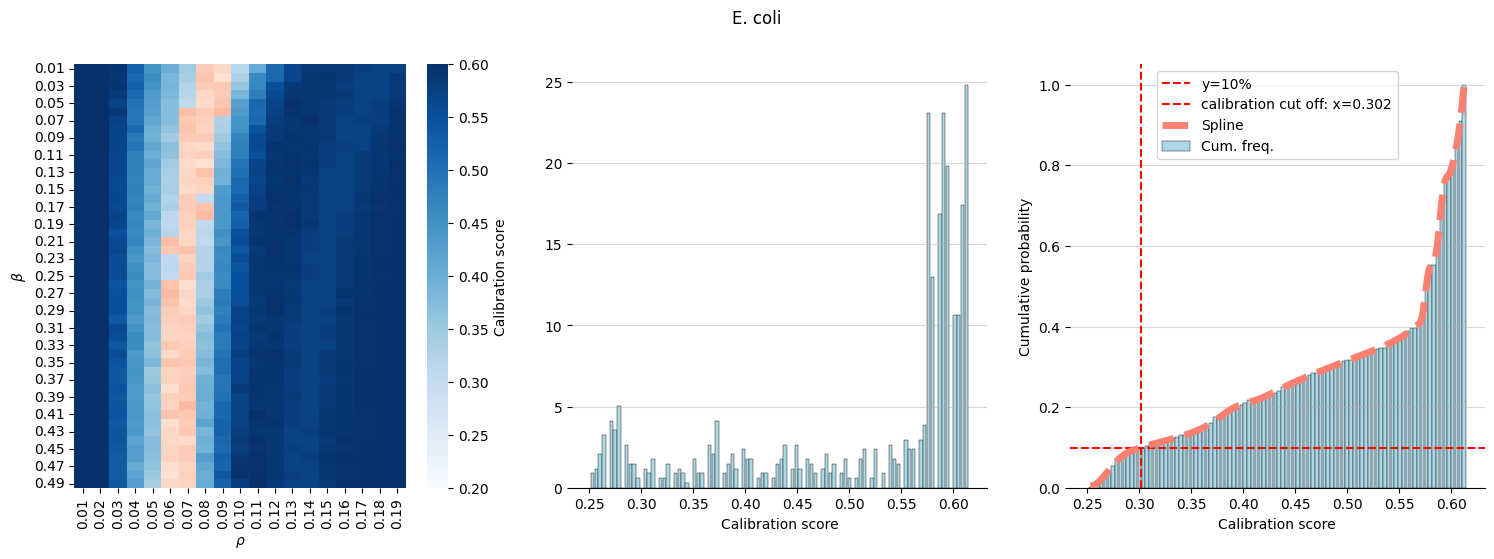

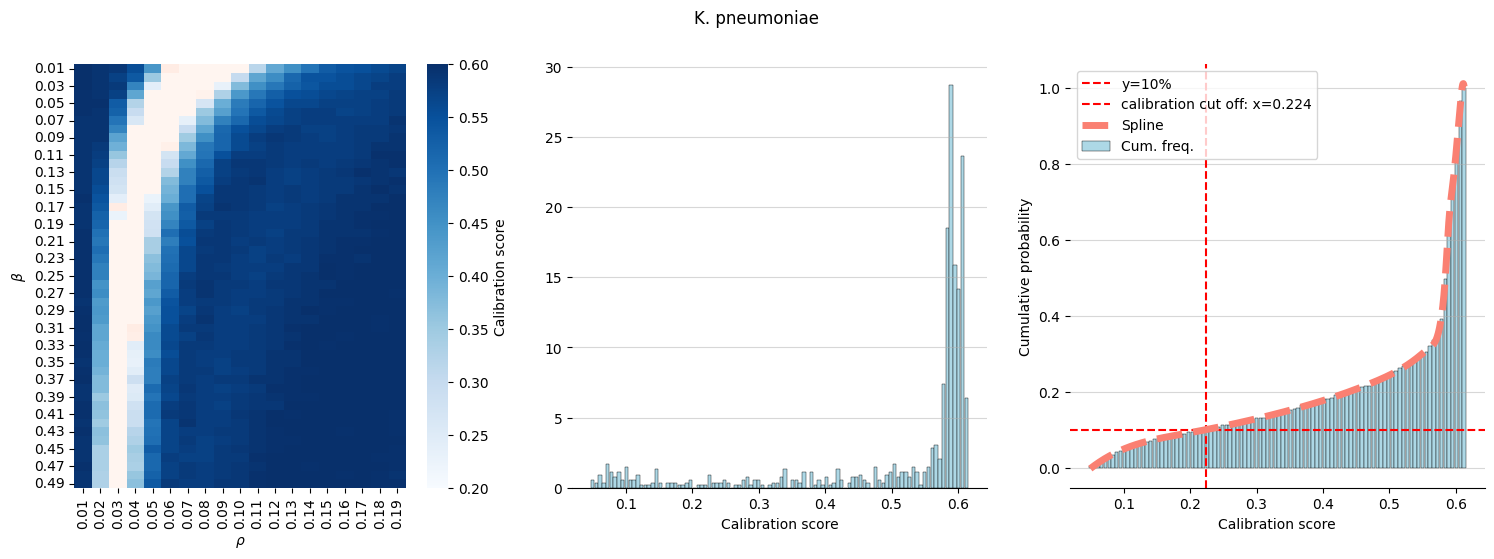

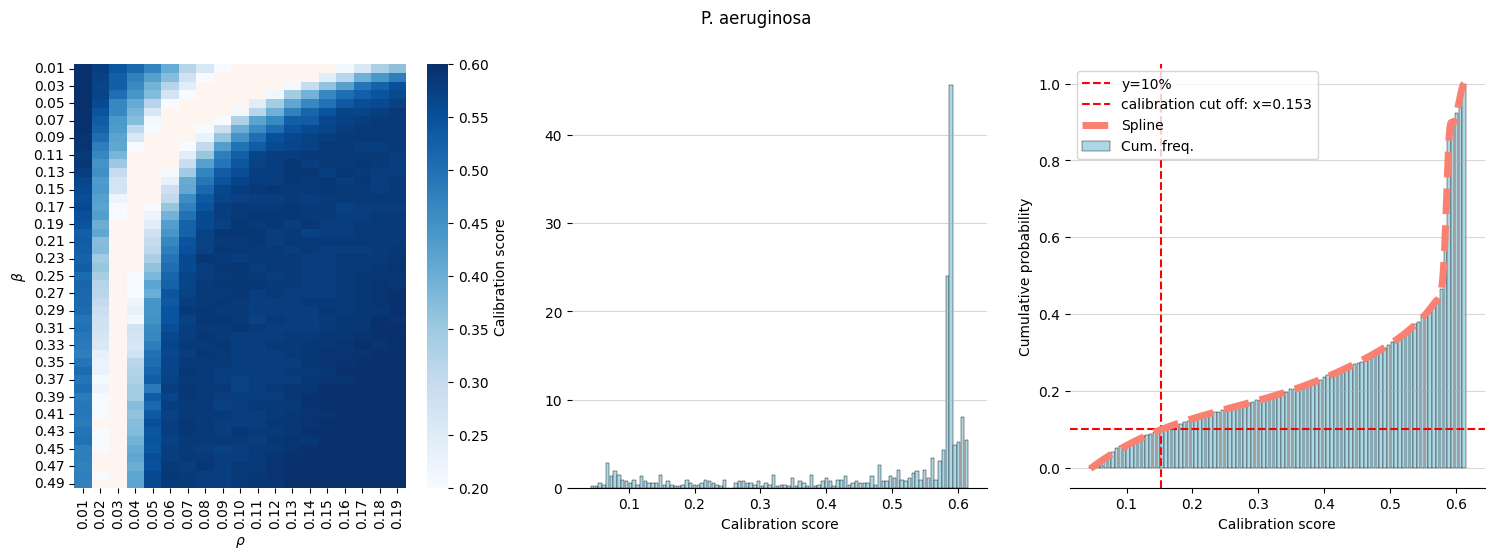

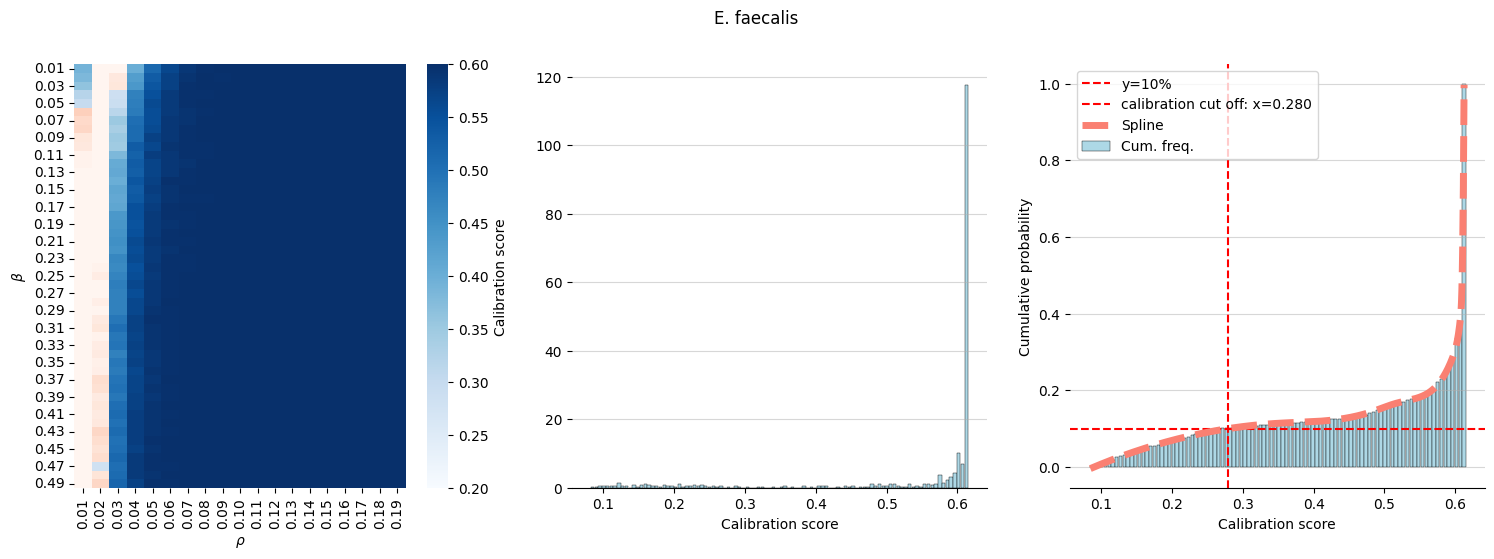

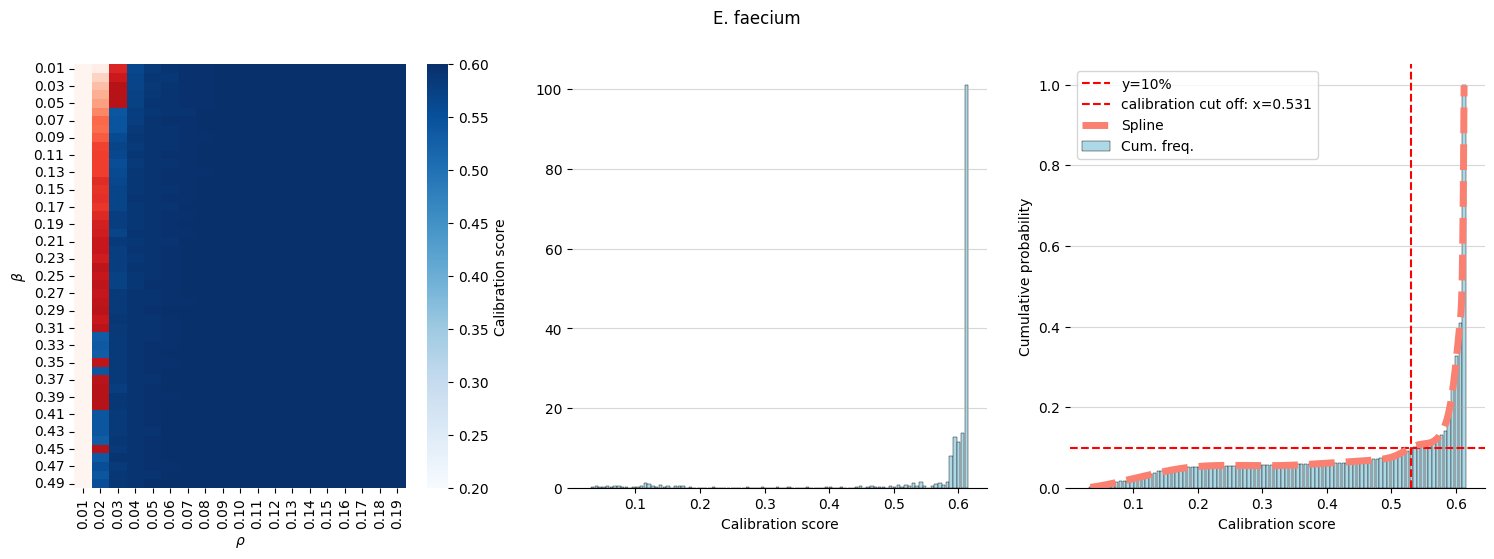

In [24]:
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from misc import amro2cute
import seaborn as sns

amro = "ESCHERICHIA COLI"


amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE', 'PSEUDOMONAS AERUGINOSA', 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']
cut_off_prob = 10/100

for amro in amro_search:

    grid_amro_df             = pd.read_csv( os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}.csv") )
    grid_amro_df["beta_str"] = grid_amro_df.beta.apply(lambda x: f"{x:.2f}")
    grid_amro_df["rho_str"]  = grid_amro_df.rho.apply(lambda x: f"{x:.2f}")

    hm_amro_df   = grid_amro_df.pivot(index='beta_str', columns='rho_str', values='calibration_score')

    freq, score = np.histogram(grid_amro_df.calibration_score, bins=100, density=True)
    cum_freq    = np.cumsum(freq); cum_freq = cum_freq/cum_freq[-1]
    score       = score[1:]


    f_cum     = UnivariateSpline(score, cum_freq, s=0.001)
    sc_range  = np.linspace(np.min(score), np.max(score), 1000)

    score_cut = sc_range[np.argmin(np.abs(f_cum(sc_range) * 100 - cut_off_prob*100))]

    fig, ax = plt.subplots(1, 3, figsize=(18.2, 5.5))



    ax[1].bar(score, freq, align="center", width=np.min(np.diff(score))*0.9, facecolor="lightblue", edgecolor="k", lw=0.3)

    ax[1].set_xlabel("Calibration score")

    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].grid(axis='y', alpha=0.5)

    ax[2].bar(score, cum_freq, align="center", width=np.min(np.diff(score))*0.9, facecolor="lightblue", edgecolor="k", lw=0.3, label="Cum. freq.")
    ax[2].axhline(y=cut_off_prob,     color='r', linestyle='--', label=f"y={int(cut_off_prob*100)}%")
    ax[2].axvline(x=score_cut, color='r', linestyle='--', label="calibration cut off: x={:.3f}".format(score_cut))

    ax[2].plot(sc_range, f_cum(sc_range), color='salmon', linestyle='--', lw=5, label="Spline")

    ax[2].set_ylabel("Cumulative probability")
    ax[2].set_xlabel("Calibration score")

    ax[2].spines['right'].set_visible(False)
    ax[2].spines['left'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[2].grid(axis='y', alpha=0.5)
    ax[2].legend()


    sns.heatmap(ax=ax[0], data=hm_amro_df, edgecolor="red", cmap='Blues', cbar_kws={'label': 'Calibration score'}, fmt=".2f", cbar=True, vmin=0.2, vmax=0.6)
    hm_amro_df[hm_amro_df > score_cut] = np.nan

    sns.heatmap(ax=ax[0], data=hm_amro_df, edgecolor="red", cmap='Reds',
                    cbar_kws={'label': 'Calibration score'}, fmt=".2f", cbar=False, vmin=0.2, vmax=0.6)

    ax[0].set_ylabel(r"$\beta$")
    ax[0].set_xlabel(r"$\rho$")

    fig.suptitle("{}".format(". ".join(amro2cute(amro).split("_")).capitalize()))
